# Deplot Output format 조사

In [14]:
import matplotlib.pyplot as plt
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration
from PIL import Image
import torch

In [15]:
# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# Load the processor and model
processor = Pix2StructProcessor.from_pretrained('google/deplot')
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot').to(device)

In [4]:
def deplot_image_to_table(image_path):
    global processor, model
    image = Image.open(image_path)
    inputs = processor(images=image, text="Generate underlying data table of the figure below:", return_tensors="pt")
    predictions = model.generate(**inputs, max_new_tokens=512)
    return processor.decode(predictions[0], skip_special_tokens=False)

In [12]:
def show_image(image_path):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Image')
    plt.show()

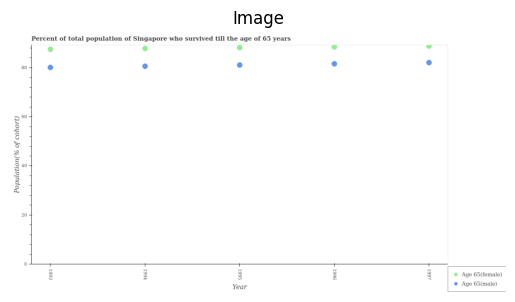

In [13]:
image_path = "D:/Project/2024 산학협력프로젝트_바이브컴퍼니/dataset test/png/png/0.png"
show_image(image_path)

In [16]:

image_path = "D:/Project/2024 산학협력프로젝트_바이브컴퍼니/dataset test/png/png/0.png"
table = deplot_image_to_table(image_path)
print(table)

# GPU 실행 3분 - local에서 돌리지 말아야겠다...
# 코랩 T5 기준 5개 돌리는데 50초 정도

<pad> TITLE | Percent of total population of Singapore who survived till the age of 65 years<0x0A>Year | Age 65(female) | Age 65(male)<0x0A>1993 | 87.40 | 80.12<0x0A>1994 | 87.71 | 80.58<0x0A>1995 | 88.09 | 81.07<0x0A>1996 | 88.44 | 81.58<0x0A>1997 | 88.76 | 82.08</s>


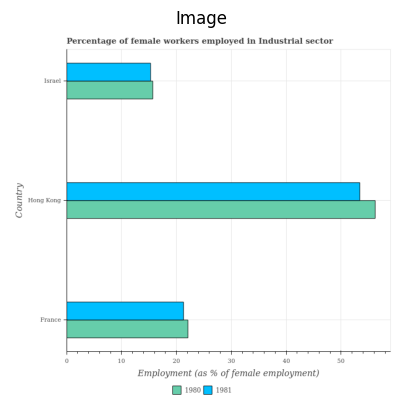

In [17]:
image_path = "D:/Project/2024 산학협력프로젝트_바이브컴퍼니/dataset test/png/png/26010.png"
show_image(image_path)

In [18]:

image_path = "D:/Project/2024 산학협력프로젝트_바이브컴퍼니/dataset test/png/png/26010.png"
table = deplot_image_to_table(image_path)
print(table)

# GPU 실행 3분 - local에서 돌리지 말아야겠다...
# 코랩 T5 기준 5개 돌리는데 50초 정도

<pad> TITLE | Percentage of female workers employed in Industrial sector<0x0A>Country | 1980 | 1981<0x0A>France | 22.10 | 21.30<0x0A>Hong Kong | 56.20 | 53.40<0x0A>Israel | 15.70 | 15.30</s>


# PlotQA finetuning

In [2]:
import json
import os
from PIL import Image
from datasets import Dataset
from transformers import Pix2StructProcessor
import pandas as pd


In [5]:
# Load JSON file
json_path = '../dataset test/deplot_format_json/deplot_format_label.json'

with open(json_path, 'r') as f:
    data = json.load(f)

In [14]:
print(type(data))
print(data['0'])

<class 'dict'>
<pad> TITLE | Percent of total population of Singapore who survived till the age of 65 years<0x0A>Year | Age 65(female) | Age 65(male)<0x0A>1993 | 87.4244 | 80.04612<0x0A>1994 | 87.75354 | 80.53889000000002<0x0A>1995 | 88.08268000000002 | 81.03166<0x0A>1996 | 88.41181999999998 | 81.52443000000002<0x0A>1997 | 88.74096 | 82.0172</s>


In [19]:
for item in data.items():
    print(type(item))
    break

<class 'tuple'>


In [34]:
# Create DataFrame from JSON data
data_list = [{"image": os.path.join('../dataset test/png/chart_image/', f"{idx}.png"), "text": text} for idx, text in data.items()]

df = pd.DataFrame(data_list[:300])
df

image  \
0      ../dataset test/png/chart_image/0.png   
1      ../dataset test/png/chart_image/1.png   
2      ../dataset test/png/chart_image/2.png   
3      ../dataset test/png/chart_image/3.png   
4      ../dataset test/png/chart_image/4.png   
..                                       ...   
295  ../dataset test/png/chart_image/295.png   
296  ../dataset test/png/chart_image/296.png   
297  ../dataset test/png/chart_image/297.png   
298  ../dataset test/png/chart_image/298.png   
299  ../dataset test/png/chart_image/299.png   

                                                  text  
0    <pad> TITLE | Percent of total population of S...  
1    <pad> TITLE | Total earnings of Belarus by tra...  
2    <pad> TITLE | Expenditure on health care (as %...  
3    <pad> TITLE | Percent of total population of V...  
4    <pad> TITLE | Pupil-teacher ratio in primary v...  
..                                                 ...  
295  <pad> TITLE | Percentage of children employmen...  
296  <pad> TITLE | Percentage of population having ...  
297  <pad> TITLE | Balance of payments recorded for...  
298  <pad> TITLE | Expenditures in tertiary public ...  
299  <pad> TITLE | Percent of total population of H...  

[300 rows x 2 columns]

In [35]:
# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(df)


In [23]:
# Load the processor
processor = Pix2StructProcessor.from_pretrained('google/deplot')

# Function to load an image
def load_image(image_path):
    return Image.open(image_path)


c:\Users\wjdrl\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [36]:
# Tokenization function
def tokenize_example(example):
    image = load_image(example["image"])
    return processor(images=image, text=example["text"], return_tensors="pt")

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_example, batched=False)


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [37]:
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

In [46]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["text"], return_tensors="pt", add_special_tokens=True)
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collator(batch):
    new_batch = {"flattened_patches": [], "attention_mask": []}
    texts = [item["text"] for item in batch]

    text_inputs = processor.tokenizer(text=texts, padding="max_length", return_tensors="pt", add_special_tokens=True, max_length=20)

    new_batch["labels"] = text_inputs.input_ids

    for item in batch:
        new_batch["flattened_patches"].append(item["flattened_patches"])
        new_batch["attention_mask"].append(item["attention_mask"])

    new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
    new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

    return new_batch


In [47]:
from transformers import TrainingArguments, Trainer, Pix2StructForConditionalGeneration

# Initialize the model
model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot')

c:\Users\wjdrl\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [55]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

In [5]:
import os

# 현재 작업 디렉토리를 얻습니다.
current_directory = os.getcwd()

print("Current Directory:", current_directory)


Current Directory: d:\Project\2024 산학협력프로젝트_바이브컴퍼니\finetuning test


In [21]:

from datasets import load_dataset 

dataset_l = load_dataset("ybelkada/football-dataset", split="train")

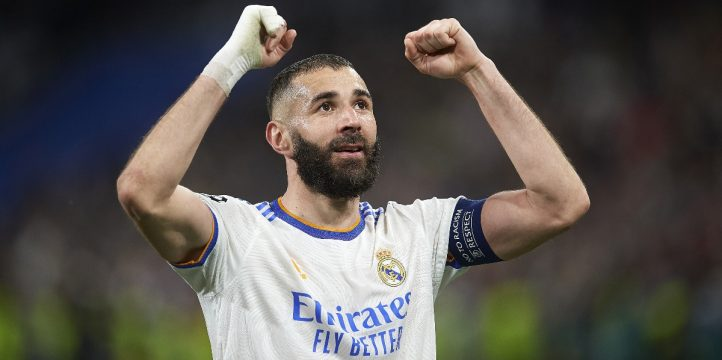

In [22]:

dataset_l[0]["image"]

<class 'PIL.JpegImagePlugin.JpegImageFile'>


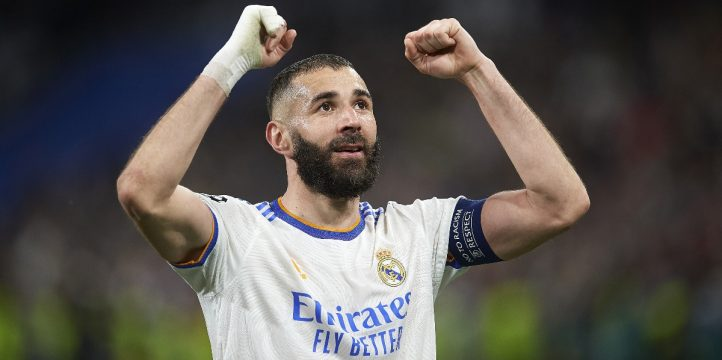

In [23]:
print(type(dataset_l[0]['image']))
dataset_l[0]['image']

In [25]:
import json
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset as HFDataset

# Function to load an image
def load_image(image_path):
    return Image.open(image_path)

# Load JSON file
json_path = '../dataset test\deplot_format_json\modified_results.json'
with open(json_path, 'r') as f:
    data = json.load(f)

# Create DataFrame from JSON data
data_list = [{"image": os.path.join('../dataset test/png/chart_image/', f"{idx}.png"), "text": text} for idx, text in data.items()]
df = pd.DataFrame(data_list[:300])

# Convert to Hugging Face dataset
dataset = HFDataset.from_pandas(df)
print(type(load_image(dataset[0]['image'])))
print(1)
'''
# Load the processor
processor = Pix2StructProcessor.from_pretrained('google/deplot')


# Tokenization function
def tokenize_example(example):
    image = load_image(example["image"])
    return processor(images=image, text=example["text"], return_tensors="pt")

# Tokenize the dataset
tokenized_dataset = dataset.map(tokenize_example, batched=False)
train_test_split = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = load_image(item["image"])  # Load the image here
        encoding = self.processor(images=image, text=item["text"], return_tensors="pt", add_special_tokens=True)
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = item["text"]
        return encoding

def collator(batch):
    new_batch = {"flattened_patches": [], "attention_mask": []}
    texts = [item["text"] for item in batch]

    text_inputs = processor.tokenizer(text=texts, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True, max_length=20)

    new_batch["labels"] = text_inputs.input_ids

    for item in batch:
        new_batch["flattened_patches"].append(item["flattened_patches"])
        new_batch["attention_mask"].append(item["attention_mask"])

    new_batch["flattened_patches"] = torch.stack(new_batch["flattened_patches"])
    new_batch["attention_mask"] = torch.stack(new_batch["attention_mask"])

    return new_batch

def main():
    # Initialize the model
    model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot')
    train_dataset = ImageCaptioningDataset(dataset, processor)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collator)

    EPOCHS = 50
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    # Directory to save checkpoints
    checkpoint_dir = "./checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # File to save logs
    log_file = "./training_log.txt"

    model.train()
    for epoch in range(EPOCHS):
        print("Epoch:", epoch)
        for idx, batch in enumerate(train_dataloader):
            labels = batch.pop("labels").to(device)
            flattened_patches = batch.pop("flattened_patches").to(device)
            attention_mask = batch.pop("attention_mask").to(device)

            outputs = model(flattened_patches=flattened_patches,
                            attention_mask=attention_mask,
                            labels=labels)

            loss = outputs.loss

            print("Loss:", loss.item())

            # Save loss to log file
            with open(log_file, 'a') as f:
                f.write(f"Epoch {epoch}, Batch {idx}, Loss: {loss.item()}\n")

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Save model checkpoint every epoch
        model_save_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.bin")
        torch.save(model.state_dict(), model_save_path)

        if (epoch + 1) % 10 == 0:
            model.eval()
            predictions = model.generate(flattened_patches=flattened_patches, attention_mask=attention_mask)
            print("Predictions:", processor.batch_decode(predictions, skip_special_tokens=True))
            model.train()

if __name__ == "__main__":
    main()
'''

<class 'PIL.PngImagePlugin.PngImageFile'>
1


'\n# Load the processor\nprocessor = Pix2StructProcessor.from_pretrained(\'google/deplot\')\n\n\n# Tokenization function\ndef tokenize_example(example):\n    image = load_image(example["image"])\n    return processor(images=image, text=example["text"], return_tensors="pt")\n\n# Tokenize the dataset\ntokenized_dataset = dataset.map(tokenize_example, batched=False)\ntrain_test_split = tokenized_dataset.train_test_split(test_size=0.1)\ntrain_dataset = train_test_split[\'train\']\neval_dataset = train_test_split[\'test\']\n\nclass ImageCaptioningDataset(Dataset):\n    def __init__(self, dataset, processor):\n        self.dataset = dataset\n        self.processor = processor\n\n    def __len__(self):\n        return len(self.dataset)\n\n    def __getitem__(self, idx):\n        item = self.dataset[idx]\n        image = load_image(item["image"])  # Load the image here\n        encoding = self.processor(images=image, text=item["text"], return_tensors="pt", add_special_tokens=True)\n        enc

# Fine Tuned Model load and run

In [1]:
def load_trained_model(checkpoint_path, processor):
    model = Pix2StructForConditionalGeneration.from_pretrained('google/deplot')
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model


In [2]:
def predict(image_path, model, processor):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    image = load_image(image_path)
    inputs = processor(images=image, return_tensors="pt").to(device)
    predictions = model.generate(**inputs)
    decoded_predictions = processor.batch_decode(predictions, skip_special_tokens=True)
    return decoded_predictions


In [7]:
# ! pip uninstall keras
# ! pip install tf-keras
# ! pip install --upgrade transformers


^C
^C


In [ ]:
import json
import os
import torch
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import Pix2StructProcessor, Pix2StructForConditionalGeneration, TrainingArguments, Trainer
from datasets import Dataset as HFDataset

processor = Pix2StructProcessor.from_pretrained('google/deplot')

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [ ]:
# Load the trained model from a specific checkpoint
checkpoint_path = "./checkpoints/model_epoch_39.bin"  # Specify the checkpoint you want to load
trained_model = load_trained_model(checkpoint_path, processor)

# Perform inference on a new image
test_image_path = "./path_to_your_test_image.png"  # Specify the path to the test image
prediction = predict(test_image_path, trained_model, processor)
print("Prediction for the test image:", prediction)

NameError: name 'processor' is not defined